CNN's are known for their capabilities to find patterns in visual data.

## Loading Data

In [ ]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu124
0.20.1+cu124


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
train_data = datasets.FashionMNIST(
    root="data", # where to download
    train=True, # training or testing data
    download=True, # download?
    transform = ToTensor(), # how to transform
    target_transform=None # transform the labels also?
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform = ToTensor(),
    target_transform=None
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 15.8MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 270kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.01MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 9.22MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader = DataLoader(dataset = train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset = test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7dc6d7440cd0>,
 <torch.utils.data.dataloader.DataLoader at 0x7dc6d7441790>)

In [ ]:
print(len(train_dataloader)) # Number of batches of size BATCH_SIZE
print(len(test_dataloader))

1875
313


In [ ]:
class_names = train_data.classes
class_idx = train_data.class_to_idx
class_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

## CNN Model

In [ ]:
class FashionMNISTModelV2(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, # Output from conv block is 10*7*7
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

In [ ]:
model = FashionMNISTModelV2(input_shape=1, # Out dataset has single channel images
                             hidden_units=10,
                             output_shape=len(class_names)).to(device)
model

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

### Convolutions Demonstration

Input tensor shape: (H_in, W_in, C_in)
- H_in: Height of the input image
- W_in: Width of the input image
- C_in: Number of input channels

Filters (kernels) shape: (F_height, F_width, C_in, N)
- F_height and F_width: The height and width of each filter.
- C_in: The depth of the filter, which matches the number of input channels.
- N: The number of filters (or output channels)

Output shape: (H_out, W_out, N)

In [ ]:
torch.manual_seed(42)
# Creating a random image batch
images = torch.randn(size=(32,3,64,64)) # [batch_size, color_channels, height, width]
test_image = images[0]
test_image.shape

torch.Size([3, 64, 64])

In [ ]:
torch.manual_seed(42)
conv_layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3,
                       stride=1, padding=0)

conv_layer(test_image).shape

torch.Size([10, 62, 62])

In [ ]:
torch.manual_seed(42)
conv_layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3,
                       stride=1, padding=1)

conv_layer(test_image).shape

torch.Size([10, 64, 64])

In [ ]:
torch.manual_seed(42)
conv_layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3,
                       stride=2, padding=1)

conv_layer(test_image).shape

torch.Size([10, 32, 32])

### Pooling Demonstration

In [ ]:
# For single image

max_pool_layer = nn.MaxPool2d(kernel_size=2)
conv_layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3,
                       stride=1, padding=1)

after_conv = conv_layer(test_image)
after_pool = max_pool_layer(after_conv)

test_image.shape, after_conv.shape, after_pool.shape

(torch.Size([3, 64, 64]), torch.Size([10, 64, 64]), torch.Size([10, 32, 32]))

In [ ]:
# Now for batch

max_pool_layer = nn.MaxPool2d(kernel_size=2)
conv_layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3,
                       stride=1, padding=1)

after_conv = conv_layer(images)
after_pool = max_pool_layer(after_conv)

images.shape, after_conv.shape, after_pool.shape

(torch.Size([32, 3, 64, 64]),
 torch.Size([32, 10, 64, 64]),
 torch.Size([32, 10, 32, 32]))

### Passing One Image

torch.Size([1, 28, 28])


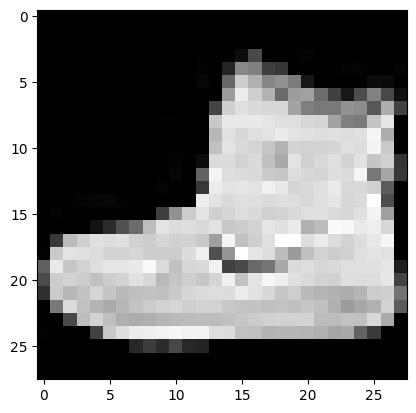

In [ ]:
test_image, label = train_data[0]
print(test_image.shape)
plt.imshow(test_image.squeeze(), cmap="gray")

In [ ]:
model.eval()
with torch.inference_mode():
  result = model(test_image.unsqueeze(0).to(device)) # It expects a batch size also, so [1, 1, 28, 28]
result

tensor([[-0.1006,  0.0536,  0.0271,  0.0249, -0.0307, -0.0862, -0.0579, -0.0219,
         -0.0390, -0.0318]])

## Preparing for Training and Testing

In [ ]:
import requests
from pathlib import Path
print("Downloading helper_functions.py")
# Note: you need the "raw" GitHub URL for this to work
request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [ ]:
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device):
  train_loss, train_acc = 0, 0
  model.train()
  for batch, (X,y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device) # Put data on device

    y_pred  = model(X)
    loss = loss_fn(y_pred, y)

    train_loss += loss
    train_acc +=accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"\nTrain loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%\n")


In [ ]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device):
  test_loss, test_acc = 0, 0

  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)

      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    print(f"\nTest loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")

In [ ]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device="cpu"):
  """
  Returns a dictionary with results of model prediction on data_loader.
  """

  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      y_pred = model(X)

      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true = y, y_pred = y_pred.softmax(dim=1).argmax(dim=1))

    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}

## Training and Evaluation

In [ ]:
torch.manual_seed(42)
epochs = 3

from tqdm.auto import tqdm

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n")
  train_step(model, train_dataloader, loss_fn, optimizer, accuracy_fn, device)
  test_step(model, test_dataloader, loss_fn, accuracy_fn, device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0


Train loss: 0.57630 | Train acc: 79.08%


Test loss: 0.38931 | Test acc: 85.97%

Epoch: 1


Train loss: 0.35560 | Train acc: 87.27%


Test loss: 0.34500 | Test acc: 87.50%

Epoch: 2


Train loss: 0.31632 | Train acc: 88.61%


Test loss: 0.32379 | Test acc: 88.21%



In [ ]:
results = eval_model(model, test_dataloader, loss_fn, accuracy_fn, device)
results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3237883448600769,
 'model_acc': 88.20886581469648}

In [ ]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device):
  preds = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for image in data:
      image = torch.unsqueeze(image, dim=0)
      image = image.to(device)
      pred_logit = model(image)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
      preds.append(torch.argmax(pred_prob))

  return preds

Bag


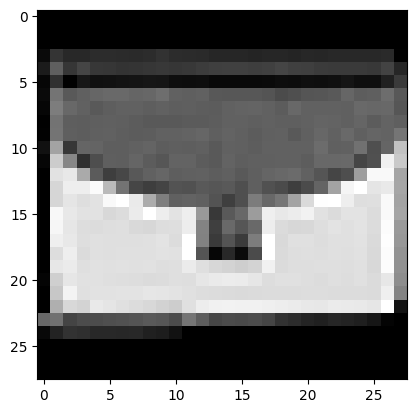

In [ ]:
import random
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

print(class_names[test_labels[0]])
plt.imshow(test_samples[0].squeeze(), cmap='gray')

In [ ]:
preds = make_predictions(model, test_samples, device)
[class_names[pred.item()] for pred in preds]

['Bag',
 'Coat',
 'Bag',
 'Dress',
 'Sandal',
 'Shirt',
 'Coat',
 'Ankle boot',
 'Shirt']

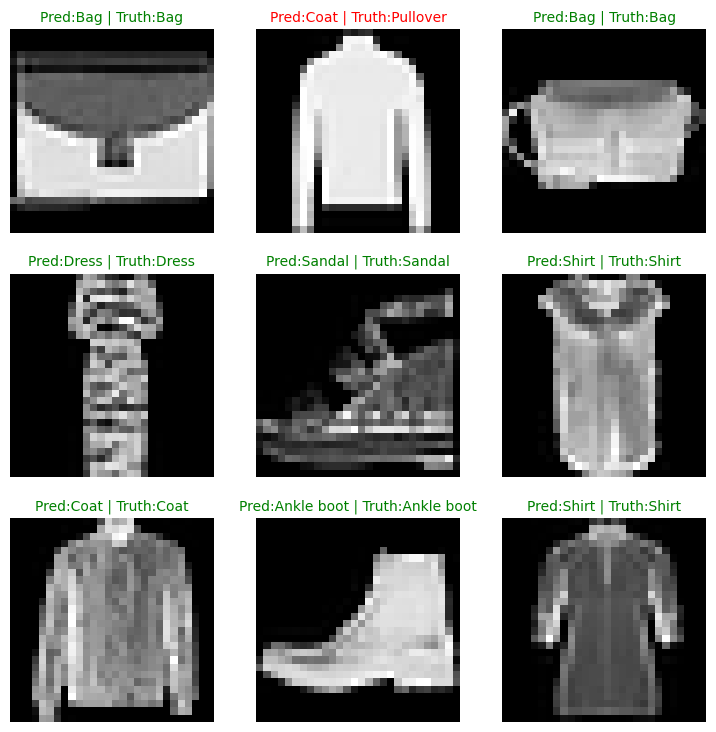

In [ ]:
plt.figure(figsize=(9,9))
rows = 3
cols = 3

for i, sample in enumerate(test_samples):
  plt.subplot(rows, cols, i+1)
  plt.imshow(sample.squeeze(), cmap='gray')

  pred_label = class_names[preds[i]]
  truth_label = class_names[test_labels[i]]

  title_text = f"Pred:{pred_label} | Truth:{truth_label}"

  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, color='green')
  else:
    plt.title(title_text, fontsize=10, color='red')
  plt.axis(False)



In [ ]:
y_preds = []
y_labels = []

model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    y_logit = model(X)
    y_pred_prob = torch.softmax(y_logit.squeeze(), dim=0)
    y_pred = y_pred_prob.argmax(dim=1)
    y_preds.append(y_pred.cpu())
    y_labels.append(y)

  # Concatenate list of predictions
  y_pred_tensor = torch.cat(y_preds)
  print(y_pred_tensor[:10])

  0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])


In [ ]:
# Torchmetrics in not in Colab natively
!pip install torchmetrics

In [ ]:
import mlxtend
mlxtend.__version__

'0.23.4'

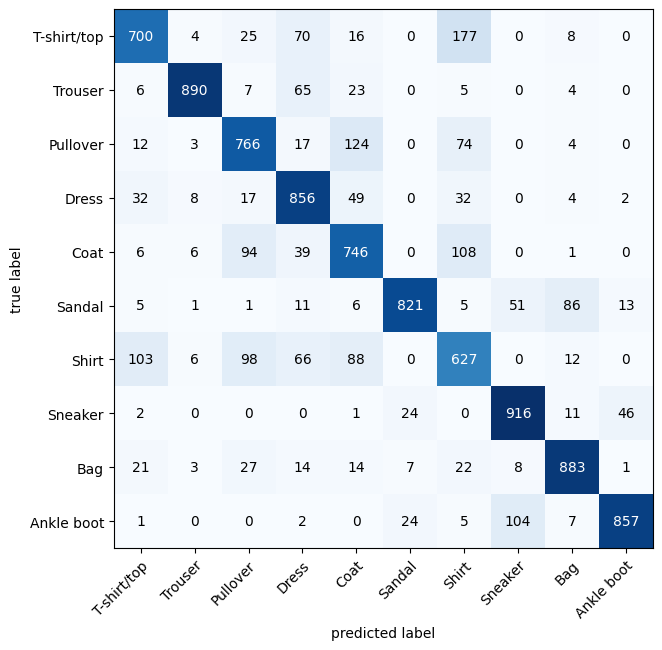

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes = len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), # Matplotlib takes numpy
                                class_names=class_names,
                                figsize=(10,7))

## Save and Load Model

In [ ]:
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "fashion_mnist_cnn_model.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

MODEL_SAVE_PATH

torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

In [ ]:
torch.manual_seed(42)
loaded_model = FashionMNISTModelV2(input_shape=1,
                                   hidden_units=10,
                                   output_shape=10)

loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

loaded_model.to(device)

<ipython-input-40-3925a04ea51d>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
loaded_results = eval_model(loaded_model, test_dataloader, loss_fn, accuracy_fn)
loaded_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3237883448600769,
 'model_acc': 88.20886581469648}

In [ ]:
torch.isclose(torch.tensor(loaded_results["model_loss"]),
              torch.tensor(results["model_loss"]), atol=1e-04) # absolute tolerance

tensor(True)